In [1]:
#pytorch utility imports
import torch
from torch.utils.data import DataLoader, TensorDataset
#neural net imports
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from torch.autograd import Variable
#import external libraries
import pandas as pd,numpy as np,matplotlib.pyplot as plt, os
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score
%matplotlib inline
#Set device to GPU or CPU based on availability
if torch.cuda.is_available():
    device = torch.device('cuda')  
else:
    device = torch.device('cpu')

In [2]:
input_folder_path = '/content'
train_df = pd.read_csv(input_folder_path + '/train.csv')
train_labels = train_df['label'].values
train_images = (train_df.iloc[:,1:].values).astype('float32')
train_images, val_images, train_labels, val_labels = train_test_split(train_images, train_labels, random_state=2020, test_size=0.2)
train_images = train_images.reshape(train_images.shape[0],1,28, 28)
val_images = val_images.reshape(val_images.shape[0],1,28, 28)

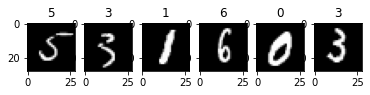

In [3]:
for i in range(0, 6):
  plt.subplot(160 + (i+1))
  plt.imshow(train_images[i].reshape(28,28), cmap=plt.get_cmap('gray'))
  plt.title(train_labels[i])

In [4]:
train_images_tensor = torch.tensor(train_images)/255.0
train_images_tensor = train_images_tensor.view(-1, 1, 28, 28)
train_labels_tensor = torch.tensor(train_labels)
train_tensor = TensorDataset(train_images_tensor, train_labels_tensor)

In [5]:
val_images_tensor = torch.tensor(val_images)/255.0
val_images_tensor = val_images_tensor.view(-1, 1, 28, 28)
val_labels_tensor = torch.tensor(val_labels)
val_tensor = TensorDataset(val_images_tensor, val_labels_tensor)

In [6]:
print("Train Labels Shape:",train_labels_tensor.shape)
print("Train Images Shape:",train_images_tensor.shape)
print("Validation Labels Shape:",val_labels_tensor.shape)
print("Validation Images Shape:",val_images_tensor.shape)

Train Labels Shape: torch.Size([6420])
Train Images Shape: torch.Size([6420, 1, 28, 28])
Validation Labels Shape: torch.Size([1606])
Validation Images Shape: torch.Size([1606, 1, 28, 28])


In [7]:
train_loader = DataLoader(train_tensor, batch_size=64, num_workers=2, shuffle=True)
val_loader = DataLoader(val_tensor, batch_size=64, num_workers=2, shuffle=True)

In [15]:
class ConvNet(nn.Module):
  def __init__(self, num_classes = 10):
    super(ConvNet, self).__init__()
    self.conv_unit_1 = nn.Sequential(
        nn.Conv2d(1, 16, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(16),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.conv_unit_2 = nn.Sequential(
        nn.Conv2d(16, 32, kernel_size=3, stride=1, padding=1),
        nn.BatchNorm2d(32),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.fc1 = nn.Linear(7*7*32, 128)
    self.fc2 = nn.Linear(128, 10)


  def forward(self, x):
    out = self.conv_unit_1(x)
    out = self.conv_unit_2(out)
    out = out.view(out.size(0), -1)
    out = self.fc1(out)
    out = self.fc2(out)
    out = F.log_softmax(out,dim=1)
    return out


In [25]:
def make_predictions(data_loader, model):
  model.eval()
  test_preds = torch.LongTensor()
  actual = torch.LongTensor()

  for data, target in data_loader:
    if torch.cuda.is_available():
      data = data.cuda()
    output = model(data)
    output = model(data)
    preds = output.cpu().data.max(1, keepdim=True)[1]
    test_preds = torch.cat((test_preds, preds), dim=0)
    actual = torch.cat((actual,target),dim=0)
  return actual, test_preds


def evaluate(data_loader, model):
  model.eval()
  loss = 0
  correct = 0
  for data, target in data_loader:
    if torch.cuda.is_available():
      data = data.cuda()
      target = target.cuda()
    output = model(data)
    loss += F.cross_entropy(output, target, size_average=False).data.item()
    predicted = output.data.max(1, keepdim=True)[1]
    correct += (target.reshape(-1,1) == predicted.
    reshape(-1,1)).float().sum()
  loss /= len(data_loader.dataset)
  print('\nAverage Val Loss: {:.4f}, Val Accuracy: {}/{}({:.3f}%)\n'.format(loss, correct, len(data_loader.dataset), 100. * correct / len(data_loader.dataset)))

In [22]:
#Create Model instance
model = ConvNet(10).to(device)
#Define Loss and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)
print(model)

ConvNet(
  (conv_unit_1): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_unit_2): Sequential(
    (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (fc1): Linear(in_features=1568, out_features=128, bias=True)
  (fc2): Linear(in_features=128, out_features=10, bias=True)
)


In [23]:
num_epochs = 5
total_step = len(train_loader)
for epoch in range(num_epochs):
  for i, (images, labels) in enumerate(train_loader):
    images = images.to(device)
    labels = labels.to(device)
      # Forward pass
    outputs = model(images)
    loss = criterion(outputs, labels)
      # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()
  print ('Epoch [{}/{}], Loss: {:.4f}' .format(epoch+1,num_epochs, loss.item()))
  evaluate(val_loader,model)

Epoch [1/5], Loss: 0.1353


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: nan, Val Accuracy: 1553.0/1606(96.700%)

Epoch [2/5], Loss: 0.0132


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: nan, Val Accuracy: 1558.0/1606(97.011%)



/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))


Epoch [3/5], Loss: 0.0095


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: nan, Val Accuracy: 1564.0/1606(97.385%)

Epoch [4/5], Loss: 0.0110


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: nan, Val Accuracy: 1557.0/1606(96.949%)

Epoch [5/5], Loss: 0.0069


/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))
/usr/local/lib/python3.7/dist-packages/torch/nn/_reduction.py:42: UserWarning: size_average and reduce args will be deprecated, please use reduction='sum' instead.
  warnings.warn(warning.format(ret))



Average Val Loss: nan, Val Accuracy: 1559.0/1606(97.073%)



In [26]:
actual, predicted = make_predictions(val_loader, model)
actual,predicted = np.array(actual).reshape(-1,1), np.array(predicted).reshape(-1,1)
print("Validation Accuracy-",round(accuracy_score(actual,predicted),4)*100)
print("\n Confusion Matrix\n",confusion_matrix(actual,predicted))

Validation Accuracy- 97.07000000000001

 Confusion Matrix
 [[152   0   0   0   0   0   0   0   0   0]
 [  0 180   0   0   0   0   0   0   0   0]
 [  0   5 173   0   0   0   0   1   0   0]
 [  1   0   0 154   0   3   0   1   0   0]
 [  2   0   0   0 145   0   2   1   1   2]
 [  0   0   1   0   0 132   0   0   0   0]
 [  0   0   0   0   0   0 166   0   0   0]
 [  0   6   1   0   0   0   0 145   0   1]
 [  2   3   2   0   0   3   0   0 142   3]
 [  1   1   0   0   0   2   0   2   0 170]]
